# Data Analytics Project - Models

# Pair 1 - BAJAJ-AUTO ARIMA Model

---

# 1. Import required modules

In [1]:
import numpy as np
import pandas as pd
from fastai.tabular.core import add_datepart
from pmdarima.arima import auto_arima
from sklearn import metrics

/home/varun487/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


---

# 2. Get Pair 1 Orders Dataset

## 2.1. Get the orders

In [2]:
orders_df = pd.read_csv('../../Preprocess/Pair1/Pair1_orders.csv')
orders_df.head()

,Date,HEROMOTOCO_Close,BAJAJ-AUTO_Close,Spread,zscore,Orders
0,2018-09-04,3184.149902,2735.550049,448.599854,2.186180,SHORT
1,2018-09-05,3145.399902,2772.300049,373.099854,1.220189,FLAT
2,2018-09-06,3164.850098,2783.100098,381.750000,1.330864,FLAT
3,2018-09-07,3329.350098,2923.550049,405.800049,1.638574,SHORT
4,2018-09-10,3278.300049,2868.600098,409.699951,1.688472,SHORT


In [3]:
orders_df.tail()

,Date,HEROMOTOCO_Close,BAJAJ-AUTO_Close,Spread,zscore,Orders
54,2018-11-27,2958.149902,2599.649902,358.500000,1.033390,FLAT
55,2018-11-28,2999.149902,2603.899902,395.250000,1.503591,SHORT
56,2018-11-29,3016.800049,2724.000000,292.800049,0.192787,FLAT
57,2018-11-30,3055.199951,2745.699951,309.500000,0.406456,FLAT
58,2018-12-03,3039.899902,2736.000000,303.899902,0.334805,FLAT


## 2.2. Visualize the orders

Text(0, 0.5, 'zscore')

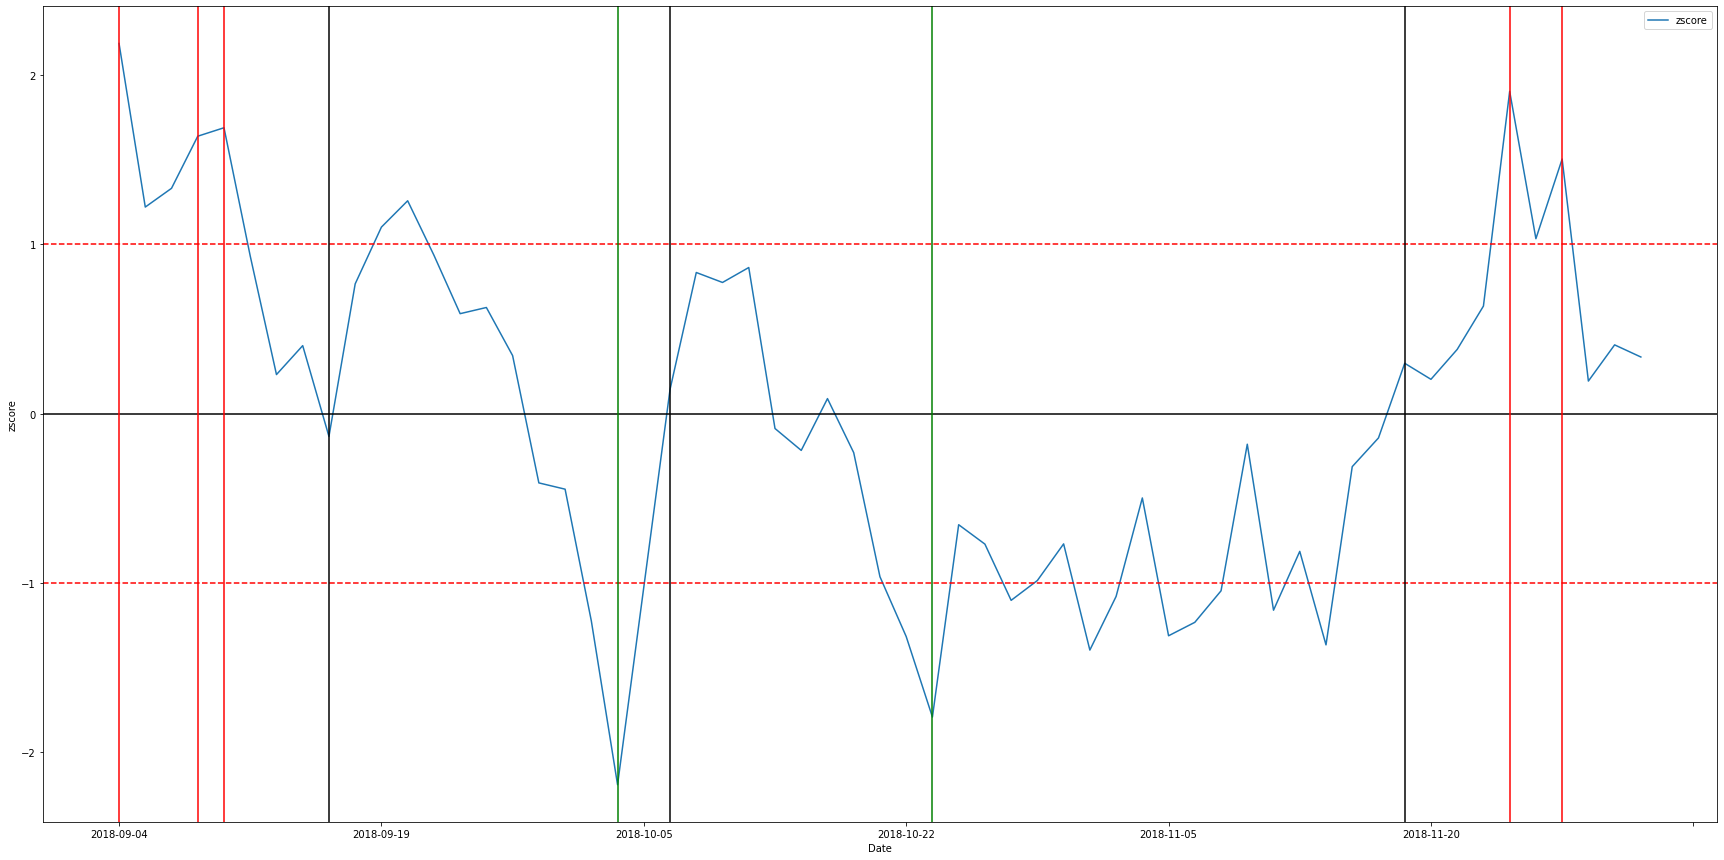

In [4]:
# Plotting the zscore of the Spread
orders_plt = orders_df.plot(x='Date', y='zscore', figsize=(30,15))

# Plotting the lines at mean, 1 and 2 std. dev.
orders_plt.axhline(0, c='black')
orders_plt.axhline(1, c='red', ls = "--")
orders_plt.axhline(-1, c='red', ls = "--")

# Extracting orders
Orders = orders_df['Orders']

# Plot vertical lines where orders are placed
for order in range(len(Orders)):
    
    if Orders[order] != "FLAT":
        
        # GREEN line for a long position
        if Orders[order] == "LONG":
            orders_plt.axvline(x=order, c = "green")
        
        # RED line for a short position
        elif Orders[order] == "SHORT":
            orders_plt.axvline(x=order, c = "red")
        
        # BLACK line for getting out of all positions at that point
        else:
            orders_plt.axvline(x=order, c = "black")

orders_plt.set_ylabel("zscore")

__In the figure above:__
- __Blue line__ - zscore of the Spread
- __Black horizontal line__ at 0 - Mean
- __Red dotted horizontal lines__ - at +1 and -1 standard deviations
- __Green vertical line__ - represents long position taken on that day
- __Red vertical line__ - represents short position taken on that day
- __Black vertical line__ - represents getting out of all open positions till that point


## 2.3 Visualize the close prices of both stocks

Text(0, 0.5, 'Price')

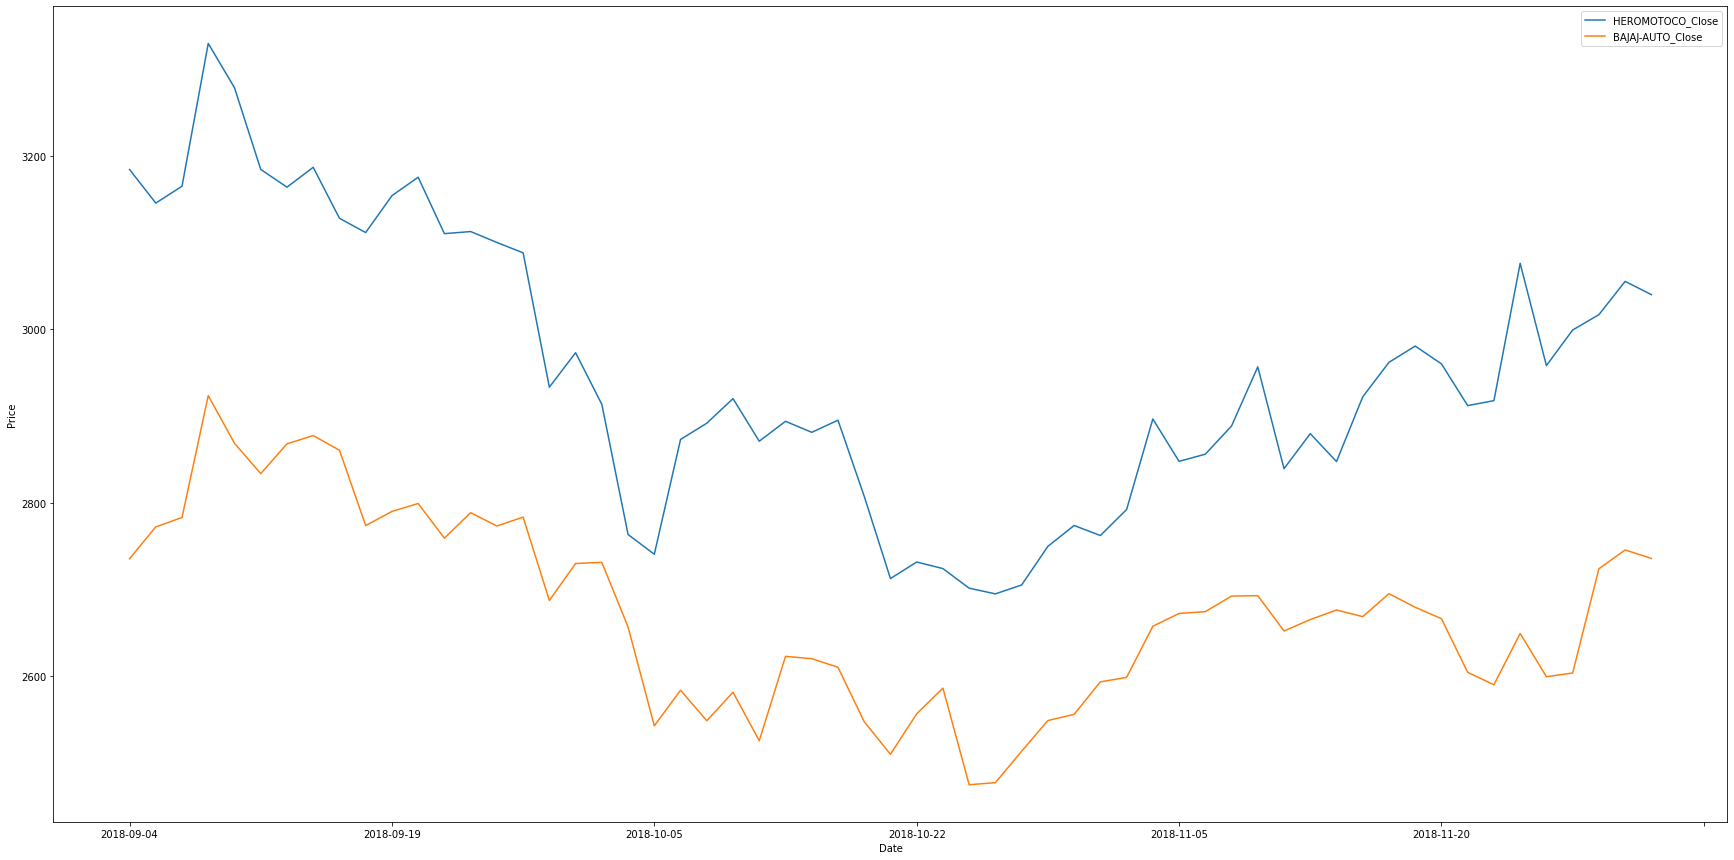

In [5]:
orders_df_plt = orders_df.plot(x='Date', y=['HEROMOTOCO_Close', 'BAJAJ-AUTO_Close'], figsize=(30,15))
orders_df_plt.set_xlabel("Date")
orders_df_plt.set_ylabel("Price")

---

# 3. BAJAJ-AUTO Linear Regression Model

## 3.1. Get the Complete BAJAJ-AUTO dataset

In [6]:
bajaj_df = pd.read_csv("../../Storage/Companies_with_names_exchange/BAJAJ-AUTONSE.csv")
bajaj_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Company,Exchange
0,2017-01-02,2654.300049,2552.000000,2642.699951,2598.500000,323342.0,2336.084473,BAJAJ-AUTO,NSE
1,2017-01-03,2632.199951,2561.449951,2594.000000,2619.199951,420196.0,2354.694336,BAJAJ-AUTO,NSE
2,2017-01-04,2698.550049,2615.949951,2625.199951,2684.100098,343922.0,2413.040283,BAJAJ-AUTO,NSE
3,2017-01-05,2730.000000,2685.000000,2694.000000,2723.350098,188686.0,2448.326416,BAJAJ-AUTO,NSE
4,2017-01-06,2739.899902,2696.699951,2721.000000,2707.350098,159484.0,2433.942383,BAJAJ-AUTO,NSE


- We can see that we have data from 2017-01-02

## 3.2. Get BAJAJ-AUTO training data

### 3.2.1 Get complete bajaj dataset

In [7]:
bajaj_df = bajaj_df.drop(columns=['High', 'Low', 'Open', 'Volume', 'Adj Close', 'Company', 'Exchange'])
bajaj_df.head()

,Date,Close
0,2017-01-02,2598.500000
1,2017-01-03,2619.199951
2,2017-01-04,2684.100098
3,2017-01-05,2723.350098
4,2017-01-06,2707.350098


- We can see that the period where the stocks are correlated and co-integration starts from 2018-09-04.
- Thus the test data for which we need to make predictions is from 2018-09-04 to when the period ends at 2018-12-03.
- We take 1 year's worth of training data for our model, which means that the time period of our training data is from 2017-09-03 to 2018-09-04.


### 3.2.2. Crop dataset within training range

In [8]:
bajaj_df_train = bajaj_df[bajaj_df['Date'] >= '2017-09-03']
bajaj_df_train.head()

,Date,Close
166,2017-09-04,2915.149902
167,2017-09-05,2950.699951
168,2017-09-06,2920.550049
169,2017-09-07,2965.449951
170,2017-09-08,2915.449951


In [9]:
bajaj_df_train = bajaj_df_train[bajaj_df_train['Date'] <= '2018-09-04']
bajaj_df_train.tail()

,Date,Close
412,2018-08-29,2689.100098
413,2018-08-30,2701.649902
414,2018-08-31,2744.850098
415,2018-09-03,2771.899902
416,2018-09-04,2735.550049


### 3.2.3 Get the training data and labels

In [10]:
bajaj_train = bajaj_df_train.copy()
bajaj_train

,Date,Close
166,2017-09-04,2915.149902
167,2017-09-05,2950.699951
168,2017-09-06,2920.550049
169,2017-09-07,2965.449951
170,2017-09-08,2915.449951
...,...,...
412,2018-08-29,2689.100098
413,2018-08-30,2701.649902
414,2018-08-31,2744.850098
415,2018-09-03,2771.899902


In [11]:
bajaj_train = bajaj_train.reset_index(drop=True)
bajaj_train = bajaj_train['Close']
bajaj_train

0      2915.149902
1      2950.699951
2      2920.550049
3      2965.449951
4      2915.449951
          ...     
246    2689.100098
247    2701.649902
248    2744.850098
249    2771.899902
250    2735.550049
Name: Close, Length: 251, dtype: float64

In [12]:
len(bajaj_train)

251

## 3.3. Get BAJAJ-AUTO Test Data

In [13]:
bajaj_test_df = orders_df.copy()
bajaj_test_df = bajaj_df[(bajaj_df['Date'] >= '2018-09-04') & (bajaj_df['Date'] <= '2018-12-03')].copy()
bajaj_test_df.head()

,Date,Close
416,2018-09-04,2735.550049
417,2018-09-05,2772.300049
418,2018-09-06,2783.100098
419,2018-09-07,2923.550049
420,2018-09-10,2868.600098


In [14]:
bajaj_test_df.tail()

,Date,Close
470,2018-11-27,2599.649902
471,2018-11-28,2603.899902
472,2018-11-29,2724.000000
473,2018-11-30,2745.699951
474,2018-12-03,2736.000000


In [15]:
bajaj_test = bajaj_test_df.copy()
bajaj_test.reset_index(drop=True, inplace=True)
bajaj_test.index += 251
bajaj_test.head()

,Date,Close
251,2018-09-04,2735.550049
252,2018-09-05,2772.300049
253,2018-09-06,2783.100098
254,2018-09-07,2923.550049
255,2018-09-10,2868.600098


In [16]:
bajaj_test.tail()

,Date,Close
305,2018-11-27,2599.649902
306,2018-11-28,2603.899902
307,2018-11-29,2724.000000
308,2018-11-30,2745.699951
309,2018-12-03,2736.000000


In [17]:
bajaj_test = bajaj_test['Close']

In [18]:
len(bajaj_test)

59

## 3.4 Create and Train BAJAJ-AUTO Model

In [19]:
model = auto_arima(bajaj_train, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(bajaj_train)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.51 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2658.845, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2586.027, Time=0.58 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2657.790, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2560.003, Time=1.72 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=6.13 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.14 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=2558.950, Time=1.16 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=2584.294, Time=0.15 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=3.49 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=2.24 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2559.961, Time=1.70 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=8.55 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=2560.736, T

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

## 3.5. Get predictions

In [20]:
forecast = model.predict(n_periods=len(bajaj_test))
forecast = pd.DataFrame(forecast, index = bajaj_test.index, columns=['Prediction'])
forecast

,Prediction
251,2758.982897
252,2758.487833
253,2753.048689
254,2750.827712
255,2751.573240
256,2656.435953
257,2587.443083
258,2575.225774
259,2564.203929
260,2569.011648


In [21]:
predictions = forecast['Prediction']
print('Mean Absolute Error:', metrics.mean_absolute_error(bajaj_test, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(bajaj_test, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(bajaj_test, predictions)))

Mean Absolute Error: 121.81543019473166
Mean Squared Error: 22522.468849934037
Root Mean Squared Error: 150.07487747765794


## 3.6. Visualize the predicitons vs test data

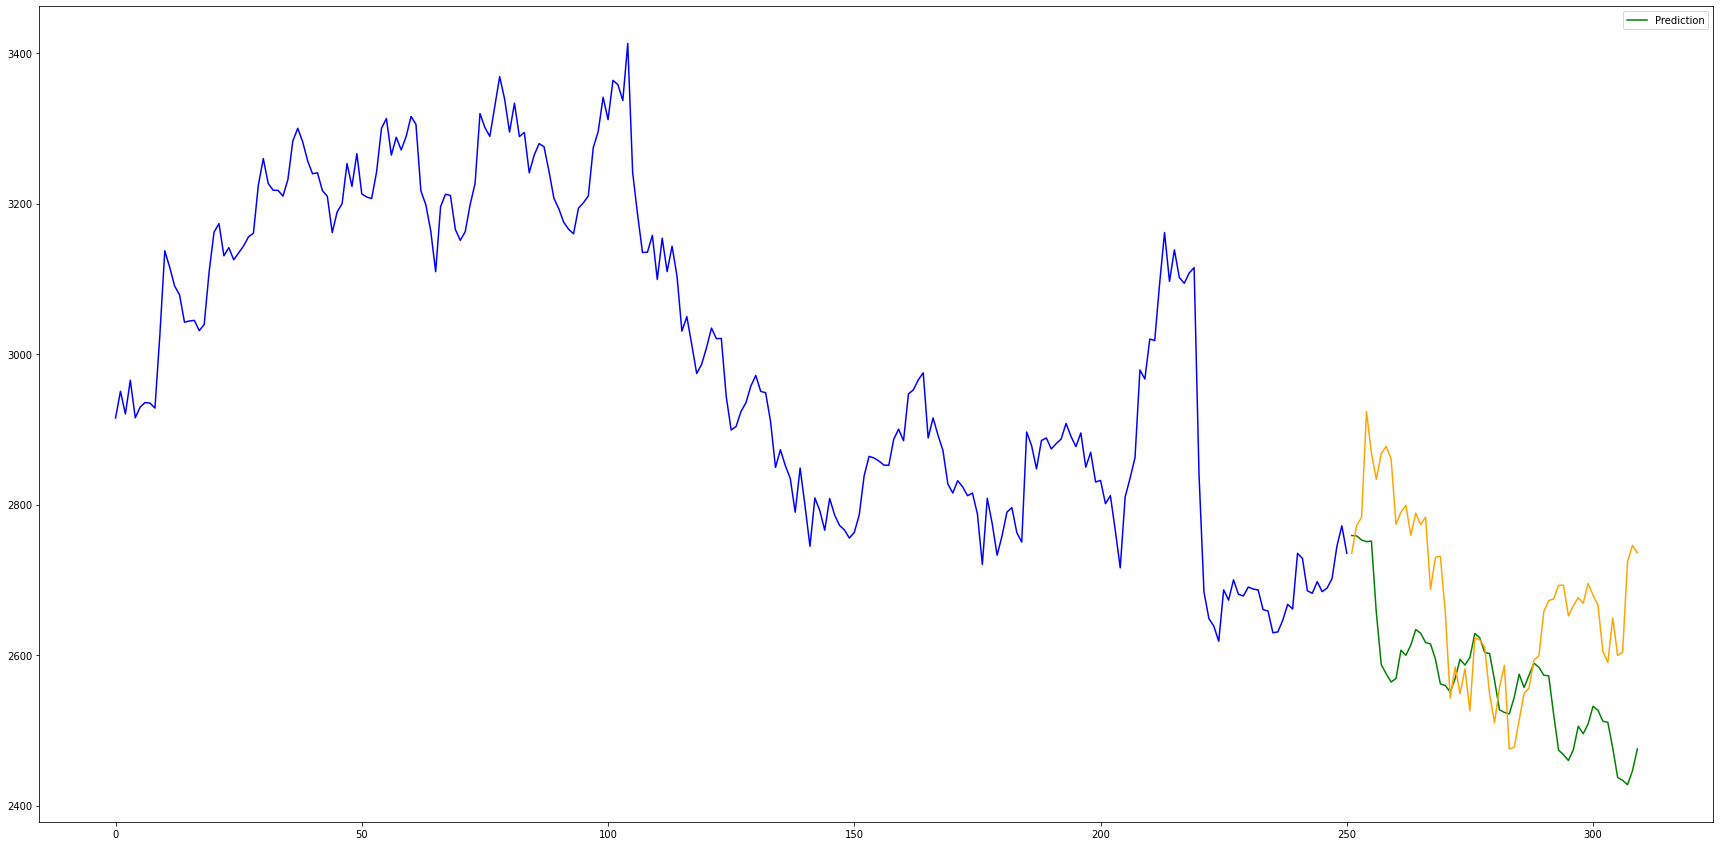

In [22]:
bajaj_model_plt = forecast.plot(y=['Prediction'], figsize=(30,15), c='green')
bajaj_model_plt.plot(bajaj_train, c='blue')
bajaj_model_plt.plot(bajaj_test, c='orange')

__In the graph above:__
- We can see the training data in blue
- The test data in orange
- The predictions made by the models in green

# 4. Put the results in a file

In [23]:
bajaj_predictions_df = pd.read_csv('Bajaj_predicitions.csv')
bajaj_predictions_df.head()

,Date,Actual_Close,Linear_regression_Close
0,2018-09-04,2735.550049,2828.063046
1,2018-09-05,2772.300049,2827.527597
2,2018-09-06,2783.100098,2826.992147
3,2018-09-07,2923.550049,2826.456697
4,2018-09-10,2868.600098,2824.743246


In [24]:
forecast = forecast.reset_index()
forecast = forecast.drop(columns='index')
bajaj_predictions_df['ARIMA_Close'] = forecast['Prediction']
bajaj_predictions_df.head()

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close
0,2018-09-04,2735.550049,2828.063046,2758.982897
1,2018-09-05,2772.300049,2827.527597,2758.487833
2,2018-09-06,2783.100098,2826.992147,2753.048689
3,2018-09-07,2923.550049,2826.456697,2750.827712
4,2018-09-10,2868.600098,2824.743246,2751.573240


In [25]:
bajaj_predictions_df.to_csv('Bajaj_predicitions.csv', index=False)